# Quantile Spatial Regression with Partial Differential Equation Regularization
Ilenia Di Battista, Alessandro Palummo @ fdaPDE Team, MOX, Department of Mathematics, Politecnico di Milano, Italy


`fdaPDE`(Palummo et al., 2025) is a C++ library with an interface to R and Python for *physics-informed spatial and functional data analysis*, at the intersection between statistics and numerical analysis. The library provides advanced statistical methods designed for data located over complex spatial domains, ranging from irregular planar regions and curved surfaces to linear networks and volumes, possibly evolving over time. The class of methods implemented in `fdaPDE` features regularization terms based on Partial Differential Equations (PDEs), which allow incorporating prior physical knowledge erived from the physics of the problem under study into the statistical modeling. This makes `fdaPDE` an extremely flexible tool for the analysis of complex data. For a review of this class of methods, refer to Sangalli (2021).

This notebook describes the `fdaPDE` Python interface for **quantile spatial regression**.

## Nonparametric quantile regression

Regression analysis is a widely used tool for studying how a response
variable behaves conditionally on a set of covariates. However, when
data substantially deviate from the Gaussian assumption -- a scenario
frequently encountered in real-world applications -- the conditional
mean may be uninformative and provide limited insight. Quantile
regression models overcome this limitation by offering a flexible
framework to analyze the entire conditional distribution, particularly
the tail characteristics of the response variable.

To estimate spatial quantile fields for complex spatial phenomena, we
refer to the method introduced in Castiglione et al. (2025). The proposed
model is particularly effective when the data exhibit skewness,
heteroscedasticity, or extreme values -- especially when these
characteristics vary across space due to physical factors such as wind
streams or water currents. The method combines the quantile regression
framework with spatial smoothing driven by Partial Differential
Equations (PDEs).

Given a real-valued random variable $Y\,,$ we consider $n$ realizations
$\left\{y_i\right\}_{i=1}^n \subset \mathbb{R}\,,$ each observed at
specific spatial locations
$\left\{\mathbf{p}_i\right\}_{i=1}^n \subset \mathcal{D}\,,$ where
$\mathcal{D} \subset \mathbb{R}^d\,,$ for $d\geq1\,,$ denotes the
*spatial domain* under consideration. Our aim is to estimate the
corresponding unknown $\alpha-$*quantile function*
$f_\alpha : \mathcal{D} \to \mathbb{R}\,,$ for any probability level
$\alpha \in (0,1)\,.$ The **nonparametric spatial regression** model for
the $\alpha-$quantile reads as:
$$Q_{Y_i|\mathbf{p}_i}(\alpha) = f_\alpha(\mathbf{p}_i)\,,  \quad \quad i=1,...,n\,. $$

We estimate the unknown quantile spatial field $f_\alpha$ by minimizing
the **penalized loss functional**:
$$  J_\alpha(f) = \frac{1}{n} \sum_{i=1}^n \rho_{\alpha}(y_i - f(\mathbf{p}_i)  ) \ + \lambda \int_\mathcal{D} (Lf(\mathbf{p}) - u(\mathbf{p}))^2 \, d\mathbf{p} \,,$$



which balances a *data fidelity* term, expressed by the **pinball loss
function** $\rho_\alpha(t) = \frac{1}{2}|t|-(\frac{1}{2}-\alpha)t\,,$
with a **regularization term** based on a problem-specific PDE. The
trade-off between these two terms is controlled by the **smoothing
parameter** $\lambda\,.$ The optimal value of the smoothing parameter is
selected via **Generalized Cross-Validation** (GCV) minimization.

Estimation is performed using the **Expectation-Maximization** (EM)
algorithm. Then, the resulting infinite-dimensional solution is
discretized through **Finite Element Method** (FEM) over a computational
mesh that approximates the spatial domain $\mathcal{D}\,.$ FEM ensures
computational efficiency and enables accurate analysis of data scattered
over irregularly shaped domains.

## Semiparametric quantile regression

The considered modeling framework can be easily generalized to include
spatial covariates, thus obtaining a semiparametric version of the
previous model. Let
$\left\{\mathbf{x}_i\right\}_{i=1}^n \subset \mathbb{R}^q$ be a vector
of $q$ spatial covariates measured at the locations
$\left\{\mathbf{p}_i\right\}_{i=1}^n\,.$ The **semiparametric spatial
regression model** for the $\alpha-$quantile reads as:
$$Q_{Y_i|\mathbf{x}_i, \mathbf{p}_i}(\alpha) = \mathbf{x}_i^\top \boldsymbol{\beta}_\alpha + f_\alpha(\mathbf{p}_i)\,, \quad \quad i=1,...,n\,.$$



We can now jointly estimate the unknown vector of *coefficients*
$\boldsymbol{\beta}_\alpha$ and the *quantile spatial field*
$f_\alpha\,.$ To do so, we include the parametric term into the data
fidelity criterion of the **penalized loss functional** as follows:
$$  J_\alpha(f) = \frac{1}{n} \sum_{i=1}^n \rho_{\alpha}(y_i - \mathbf{x}_i^\top \boldsymbol{\beta}- f(\mathbf{p}_i)  ) \ + \lambda \int_\mathcal{D} (Lf(\mathbf{p}) - u(\mathbf{p}))^2 \, d\mathbf{p}\,.$$


Finally, the estimation and discretization procedures follow the same
steps as in the nonparametric model.

In this notebook we describe how the `fdaPDE` library gives easy access to the described physics-informed Quantile Spatial Regression model , hereafter referred
to as `QSR-PDE`.


In [ ]:
## Google-colab setup cell, you can skip this cell if you are running the notebook locally
import sys

if "google.colab" in sys.modules:
  # clone data and utilites
  !git clone https://github.com/fdaPDE/course-materials.git
  %cd course-materials/courses/[2026-Rome]-Advanced-Topics-in-Statistical-Machine-Learning/notebook

  # install dependencies
  !pip install numpy matplotlib pandas geopandas folium branca rasterio rioxarray seaborn IPython
  !pip install -i https://test.pypi.org/simple/ fdaPDE

We start by loading some additional Python libraries and helper functions used for graphical purposes only:

In [1]:
# Import additional libraries 
import numpy as np
import matplotlib.pyplot as plt

# Load helper  functions for plotting
import sys
sys.path.append("..")

from utils.utils import (
    plot_domain,
    display_folium_map
)

## Application to Switzerland rainfall data

As a benchmark application in enviornmental sciences, we analyze the
**Switzerland rainfall dataset**, which collects $462$ rainfall
measurements (in $10 \, \mu m$ units) recorded on May 8, 1986. This
dataset is well known in the statistical community, with several studies
dedicated to its analysis, including Dubois et al. (2003) and Dubois et al. (2007). 
Starting from this set of georeferenced data, the
goal is to estimate spatial quantile maps of the rainfall distribution.
To compare the median tendency of the phenomenon with tail behavior, we
focus on the estimates for both $50\%$ and $90\%$ quantile fields,
assessing whether some regions are more prone to experience extreme
values and to identify potential spatial patterns associated with
high-risk events.

### 1. Spatial domain

First, we load the boundary nodes of our domain of interest, which are stored sequentially in clockwise order. The ordering of the boundary nodes will be essential for plotting purposes. We then construct the matrix of boundary segments, with each row containing the indices of the boundary nodes that define a segment.

In [2]:
## [SPATIAL DOMAIN]
# Load the boundary nodes
boundary_nodes = np.loadtxt("../Data/QSRPDE_2D/boundary_coords.txt")  # (lon, lat)

# Print first 5 boundary nodes
print("First 5 coordinates of boundary nodes (lon/lat):")
print(boundary_nodes[:5, :], "\n")

# Create boundary segments (consecutive boundary nodes are connected)
n = boundary_nodes.shape[0]
boundary_segments = np.column_stack((np.arange(n-1), np.arange(1, n)))

# Close the loop (connect the last node to the first)
boundary_segments = np.vstack((boundary_segments, [n-1, 0]))

First 5 coordinates of boundary nodes (lon/lat):
[[ 9.6586889  47.13000629]
 [ 9.86335901 47.10578023]
 [ 9.97198667 47.01739337]
 [10.09042206 46.95084373]
 [10.20173895 46.95442815]] 



The domain can be interactively visualized using the `folium` Python package (Python Visualization Team, 2024).

In [3]:
# Interactive plot 
plot_domain(
    boundary_nodes = boundary_nodes,
    fill_color     = "grey",
    fill_opacity   = 0.4,
    border_color   = "black",
    border_weight  = 2, 
    zoom_start     = 7
)

Figure 1: Spatial domain of interest – Switzerland.

Once the geometrical boundary of the region of interest is defined, we proceed by constructing a suitable discretization of the domain. Such discretization might be obtained using any external Delaunay mesh generator, such as that available in package `pyMesh` or `scipy`. Here, for simplicty, we import the mesh nodes, mesh elements and boundary description from already preprocessed files:

In [4]:
## [MESH]
# Read mesh nodes, boundary nodes and mesh elements
mesh_nodes    = np.loadtxt("../Data/QSRPDE_2D/nodes.txt"   , dtype = float)
mesh_boundary = np.loadtxt("../Data/QSRPDE_2D/boundary.txt", dtype = float)
mesh_cells    = np.loadtxt("../Data/QSRPDE_2D/cells.txt"   , dtype = int  )

# Print shapes
print(f"Mesh nodes shape: {mesh_nodes.shape}")
print(f"Mesh cells shape: {mesh_cells.shape}\n")

Mesh nodes shape: (1086, 2)
Mesh cells shape: (2019, 3)



Next, we embed this informations into an object of class `Mesh`, loaded from the geometry module of the `fdaPDE` library.

In [5]:
# Import Mesh from fdaPDE.geometry module
from fdaPDE.geometry import Mesh

# Define mesh of the spatial domain
mesh_switzerland = Mesh(
    nodes    = mesh_nodes,
    cells    = mesh_cells,
    boundary = mesh_boundary
)

# Print short summary of the mesh
print(mesh_switzerland)

2D mesh
Bounding box:   xmin: 5.90952302689424 ymin: 45.7927767731332 xmax: 10.5840309137745 ymax: 47.8322004603264
Number of nodes: 1086
Number of cells: 2019


We visualize the resulting mesh of the spatial domain of interest using the `mapplot` method of the `Mesh` data-type.

In [6]:
# Interactive plot
mesh_switzerland.mapplot(
    boundary_nodes      = boundary_nodes,
    domain_fill_opacity = 0.3,
    mesh_weight         = 0.6,
    mesh_opacity        = 0.7, 
    zoom_start          = 7
)

Figure 2: Regular mesh of the Switzerland domain with $1\,128$ nodes and
$2\,077$ triangles.

### 2. Data

Starting from the `Mesh` previously defined, we define a `GeoFrame` instance supported on `mesh_switzerland`.

In [7]:
# Import GeoFrame from fdaPDE
from fdaPDE import GeoFrame

# Define geoframe over the switzerland domain
switzerland = GeoFrame(domain = mesh_switzerland)
print(switzerland)

Geoframe with 0 layers
Bounding box:   xmin: 5.90952302689424 ymin: 45.7927767731332 xmax: 10.5840309137745 ymax: 47.8322004603264
Number of nodes: 1086
Number of cells: 2019



We import the data locations from the file `QSRPDE_2D/locations.txt` and the corresponding observed values from the file `QSRPDE_2D/log_rainfall.txt`, both as a `np.ndarray` object. As observations are geo-referenced, we add a `point` data layer to the geoframe object, thus obtaining a data description compatible with the implementation of the proposed regression method.

In [8]:
## [DATA]
# Load data locations and data values
locations    = np.loadtxt("../Data/QSRPDE_2D/locations.txt"   , dtype = float)
log_rainfall = np.loadtxt("../Data/QSRPDE_2D/log_rainfall.txt", dtype = float)

print(f"Locations shape: {locations.shape}")
print(f"Observation shape: {log_rainfall.shape}\n")

# Print first 5 values
print("First 5 values of the log_rainfall variable:")
print(log_rainfall[:5])


Locations shape: (462, 2)
Observation shape: (462,)

First 5 values of the log_rainfall variable:
[0.60976557 0.19062036 0.3220835  0.23111172 0.44468582]


In [9]:
# Add layer with data to the geoframe object
switzerland.insert("rainfall", layer_type = "point", geo = locations, data = log_rainfall)

# Print summary of the groframe
print(switzerland)

Geoframe with 1 layer
Bounding box:   xmin: 5.90952302689424 ymin: 45.7927767731332 xmax: 10.5840309137745 ymax: 47.8322004603264
Number of nodes: 1086
Number of cells: 2019

Layer: rainfall
Type:  POINT
Dims:  462, 1
First 6 data rows:
                             V1
               <POINT>  <flt64>
 (8.585260, 47.778575) 0.609766
 (8.637467, 47.749564) 0.190620
 (8.443961, 47.745972) 0.322083
 (8.760957, 47.721855) 0.231112
 (8.425719, 47.695665) 0.444686
 (8.701118, 47.690768) 0.000000



In [10]:
print(f"Geoframe number of layers: {switzerland.n_layers}")
print(f"Geoframe layer name: {switzerland.names}")
print(f"Geoframe layer columns names: {switzerland.colnames}")

print("Geoframe mesh information:")
print(switzerland.mesh)

print("Geoframe data information:")
print(switzerland["rainfall"])

Geoframe number of layers: 1
Geoframe layer name: ['rainfall']
Geoframe layer columns names: ['V1']
Geoframe mesh information:
2D mesh
Bounding box:   xmin: 5.90952302689424 ymin: 45.7927767731332 xmax: 10.5840309137745 ymax: 47.8322004603264
Number of nodes: 1086
Number of cells: 2019
Geoframe data information:
                             V1
               <POINT>  <flt64>
 (8.585260, 47.778575) 0.609766
 (8.637467, 47.749564) 0.190620
 (8.443961, 47.745972) 0.322083
 (8.760957, 47.721855) 0.231112
 (8.425719, 47.695665) 0.444686
 (8.701118, 47.690768) 0.000000


To visualize the rainfall distribution, we plot the data across the Switzerland region in logarithmic scale.

In [11]:
# Interactive plot
m_data = switzerland["rainfall"].mapplot(
    "V1",
    boundary_nodes = boundary_nodes,
    cmap_name      = "Blues",
    marker_radius  = 5,
    domain_fill    = False, 
    zoom_start     = 7,
    marker_opacity = 1
)

display_folium_map([m_data])

Figure 3: Switzerland rainfall data collected at 462 locations, shown in logarithmic scale.

### 3. QSR-PDE model fitting for physics-informed smoothing

The data exhibit strong anisotropic patterns across the domain. To
account for the clear anisotropy observed in the data, we incorporate a
stationary anisotropic diffusion term into the model. To do so, we
define the differential operator as
$$Lf(\mathbf{p}) = \text{div}(\mathbf{K}\nabla f(\mathbf{p})) \quad \forall \mathbf{p} \in \mathcal{D}\,.$$
The anisotropy tensor $\mathbf{K}$ is estimated using the **parameter
cascading algorithm** presented in Bernardi et al. (2018), yielding an
orientation angle of $140^\circ (2.45 \ \text{rad})$ and an intensity of
anisotropy of $6.00\,.$

In [12]:
## [DIFFUSION TENSOR]
K = np.array([
    [1.229618413471819, 1.001009926596135],
    [1.001009926596135, 1.628164356689574]
])

#### 3.1 Physics-informed smoothing for the 50% quantile level

We can now compute the physics-informed quantile spatial estimate, for
the $50\%$ probability level. To this end, we use the `QSRPDE` function,
setting the quantile level with the option `level = 0.5` and providing
the anistropic diffusion tensor using a `FeElliptic` penalty, specifying `K` as anisotropic diffusion tensor. The actual fitting is obtained by calling the `fit` method
of the class `QSRPDE`. The optimal smoothing parameter $\lambda$ is
selected via Generalized Cross-Validation (GCV) minimization using the `GridSearch` optimizer.

In [13]:
# Import FeFunction, QSRPDE, FeElliptic, GCV, GridSearch from fdaPDE
from fdaPDE.fem import FeFunction
from fdaPDE.models import QSRPDE, FeElliptic, GCV
from fdaPDE.optimization import GridSearch

## [PHYSICS-INFORMED QUANTILE REGRESSION]
# Set up the finite element function (order 1)
f_50 = FeFunction(domain = mesh_switzerland, fe_type = "P1")

# Proposed value for the smoothing parameter
lambda_grid = 10**(np.arange(-6.0, -3.0, 0.2))

# Physics informed smoothing model
m_50 = QSRPDE("V1 ~ f_50", data = switzerland, level = 0.5, penalty =  FeElliptic(K = K))

# Physics informed smoothing fit with grid search for GCV minimization
fit_m50 = m_50.fit(calibration_ = GCV(optimizer = GridSearch(lambda_grid), seed=425))  

For diagnostic purposes, it is possible to inspect the behavior of the GCV indices as a
function of the values proposed for the smoothing parameter $\lambda\,.$

lambda_opt = 1.0000e-05


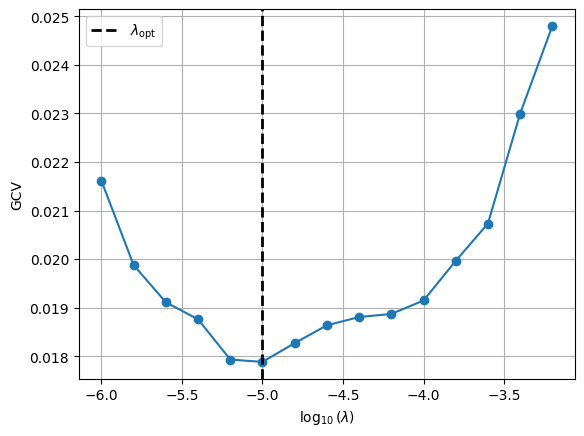

In [14]:
# GCV indices
gcv_values = fit_m50["values"] 

# Optimal value selected for the smoothing parameter
lambda_opt = fit_m50["optimum"]
print(f"lambda_opt = {lambda_opt:.4e}")

# Plot of the GCV curve
plt.plot(np.log10(lambda_grid), gcv_values, '-o')   
plt.xlabel(r"$\log_{10}(\lambda)$")
plt.ylabel("GCV")

plt.axvline(
    np.log10(lambda_opt),
    linestyle = "--",
    linewidth = 2,
    color     = "black",
    label     = r"$\lambda_{\mathrm{opt}}$"
)

plt.grid(True)
plt.legend()
plt.show()

Figure 4: GCV curve for the $50\%$ quantile field.


The GCV curve is convex with minimum realized at the optimal value
selected by the method -- specifically $1e-5\,.$

The code below enables visualization of the $50\%$ quantile estimate computed above in the
logarithmic scale. 


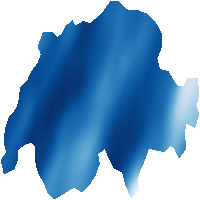

In [15]:
# Interactive plot
m_f50 = f_50.mapplot(
    boundary_nodes = boundary_nodes,
    layer_name     = "log.rainfall", 
    zoom_start     = 7,
    border_weight  = 3
)

m_data = switzerland["rainfall"].mapplot(
    "V1",
    boundary_nodes = boundary_nodes,
    cmap_name      = "Blues",
    marker_radius  = 5,
    domain_fill    = False, 
    zoom_start     = 7,
    domain_weight  = 3
)

display_folium_map(
    maps        = [m_f50, m_data],
    nrows       = 1,
    ncols       = 2
)


Figure 5: Rainfall $50\%$ quantile estimate in the logarithmic scale
computed by the physics-informed `QSR-PDE` with optimal  $\lambda$  $1e-05$
selected via GCV minimization using grid search method (left); rainfall data in the logarithmic scale observed at 462 monitoring stations located across Switzerland (right).



#### 3.2 Physics-informed smoothing for the 90% quantile level

We repeat the analysis for the quantile level $\alpha = 90\%$ and we
compare the two fitted quantile fields. The code is identical as for the $50\%$ quantile, apart for the different specification of the `alpha` argument

In [16]:
## [PHYSICS-INFORMED QUANTILE REGRESSION]
# Set up the finite element function (order 1)
f_90 = FeFunction(domain = mesh_switzerland, fe_type = "P1")

# Proposed value for the smoothing parameter
lambda_grid = 10**(np.arange(-7.0, -4.0, 0.2))

# Physics informed smoothing model
m_90 = QSRPDE("V1 ~ f_90", data = switzerland, level = 0.9, penalty =  FeElliptic(K = K))

# Physics informed smoothing fit with grid search for GCV minimization
fit_90 = m_90.fit(calibration_ = GCV(optimizer = GridSearch(lambda_grid), seed=425))  

We inspect the behavior of the GCV indices as a function of the values
proposed for the smoothing parameter $\lambda\,.$

lambda_opt = 3.9811e-06


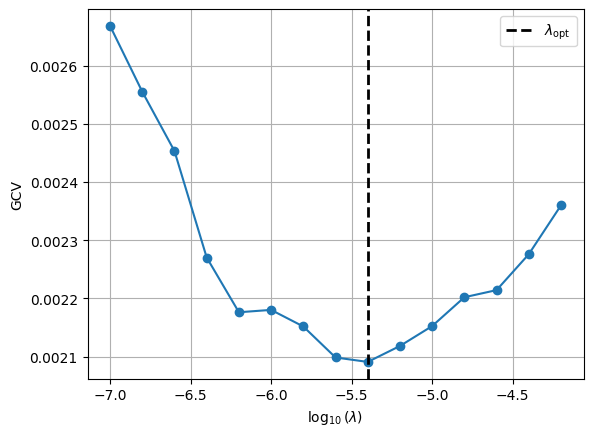

In [17]:
# GCV indices
gcv_values = fit_90["values"] 

# Optimal value selected for the smoothing parameter
lambda_opt = fit_90["optimum"]
print(f"lambda_opt = {lambda_opt:.4e}")

# Plot of the GCV curve
plt.plot(np.log10(lambda_grid), gcv_values, '-o')   
plt.xlabel(r"$\log_{10}(\lambda)$")
plt.ylabel("GCV")

plt.axvline(
    np.log10(lambda_opt),
    linestyle = "--",
    linewidth = 2,
    color     = "black",
    label     = r"$\lambda_{\mathrm{opt}}$"
)

plt.grid(True)
plt.legend()
plt.show()

Figure 6: GCV curve for the $90\%$ quantile field.

Also in this case, the GCV curve is convex with minimum realized at the
optimal value selected by the method, specifically $3.98e-06\,.$

We visualize the $90\%$ quantile estimate computed above in the
logarithmic scales.


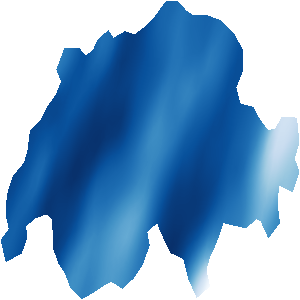
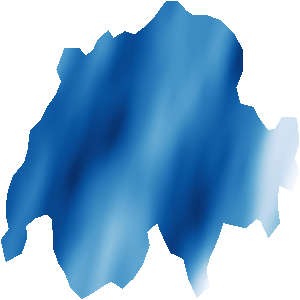

In [18]:
# Interactive plot
m_f50 = f_50.mapplot(
    boundary_nodes = boundary_nodes,
    layer_name     = "log.rainfall 50", 
    zoom_start     = 7,
    border_weight  = 3,    
    nx             = 300,
    ny             = 300
)

m_f90 = f_90.mapplot(
    boundary_nodes = boundary_nodes,
    layer_name     = "log.rainfall 90", 
    zoom_start     = 7,
    border_weight  = 3,
    nx             = 300,
    ny             = 300
)


display_folium_map(
    maps        = [m_f50, m_f90],
    nrows       = 1,
    ncols       = 2
)


Figure 7: Rainfall $50\%$ (left) and $90\%$ (right) quantile estimate in the logarithmic scale computed by the physics-informed `QSR-PDE`. The optimal smoothing parameters  $\lambda$ are selected via GCV, with values of $1e-05\,.$ and $3.98e-06\,.$ respectively.



Comparing the two estimated quantile fields, we observe that the median
surface appears considerably smoother than the $90\%$ quantile. This is
expected, as the median is more robustness to skewness and local
outliers. On the other hand, the $90\%$ quantile surface exhibits
several pronounced local spikes, highlighting regions prone to extreme
precipitation. These peaks suggest that certain areas experience
significantly higher rainfall extreme events, highlighting the
importance of analyzing the upper-tail quantiles when assessing rainfall
risk.

## References

Bernardi, M. S., Carey, M., Ramsay, J. O., & Sangalli, L. M. (2018). Modeling spatial anisotropy via regression with partial differential regularization. Journal of Multivariate Analysis, 167, 15–30. https://doi.org/10.1016/j.jmva.2018.03.014

Castiglione, C., Arnone, E., Bernardi, M., Farcomeni, A., & Sangalli, L. M. (2025). PDE-regularised spatial quantile regression. Journal of Multivariate Analysis, 205. https://doi.org/10.1016/j.jmva.2024.105381

Dubois, G., Malczewski, J., & De Cort, M. J. M. R. (2003). Mapping radioactivity in the environment. Spatial interpolation comparison 97. European Commission.

Dubois, G., Pebesma, E. J., & Bossew, P. (2007). Automatic mapping in emergency: A geostatistical perspective. International Journal of Emergency Management, 4(3), 455–467.

Palummo, A., Clemente, A., Sangalli, E., Arnone, Formaggia, L., & Maria, L. (2025). fdaPDE: Physics-informed statistical learning. url: https://github.com/fdaPDE/fdaPDE-R.

Python Visualization Team. (2024). Folium (Version 0.20.0) [Computer software]. https://github.com/python-visualization/folium

Sangalli, L. M. (2021). Spatial regression with partial differential equation regularisation. International Statistical Review, 89(3), 505–531. https://doi.org/10.1111/insr.12444
